In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix, roc_curve
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


%matplotlib inline

# Установим тип графиков
sns.set(style="ticks")

# Для лучшего качество графиков
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# Установим ширину экрана для отчета
pd.set_option("display.width", 80)

## **Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных**

In [331]:
# Загрузим набор данных и выведем её первые пять записей
data = pd.read_csv('Admission_Predict.csv')
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [332]:
# Вычислим размер датасета 
data.shape

(400, 9)

In [333]:
# Увидим, из каких колонок состоит датасет
data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [334]:
# Поймем какими типами данных заполнены колонки 
data.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

In [335]:
# Проверим наличие пустых значений
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

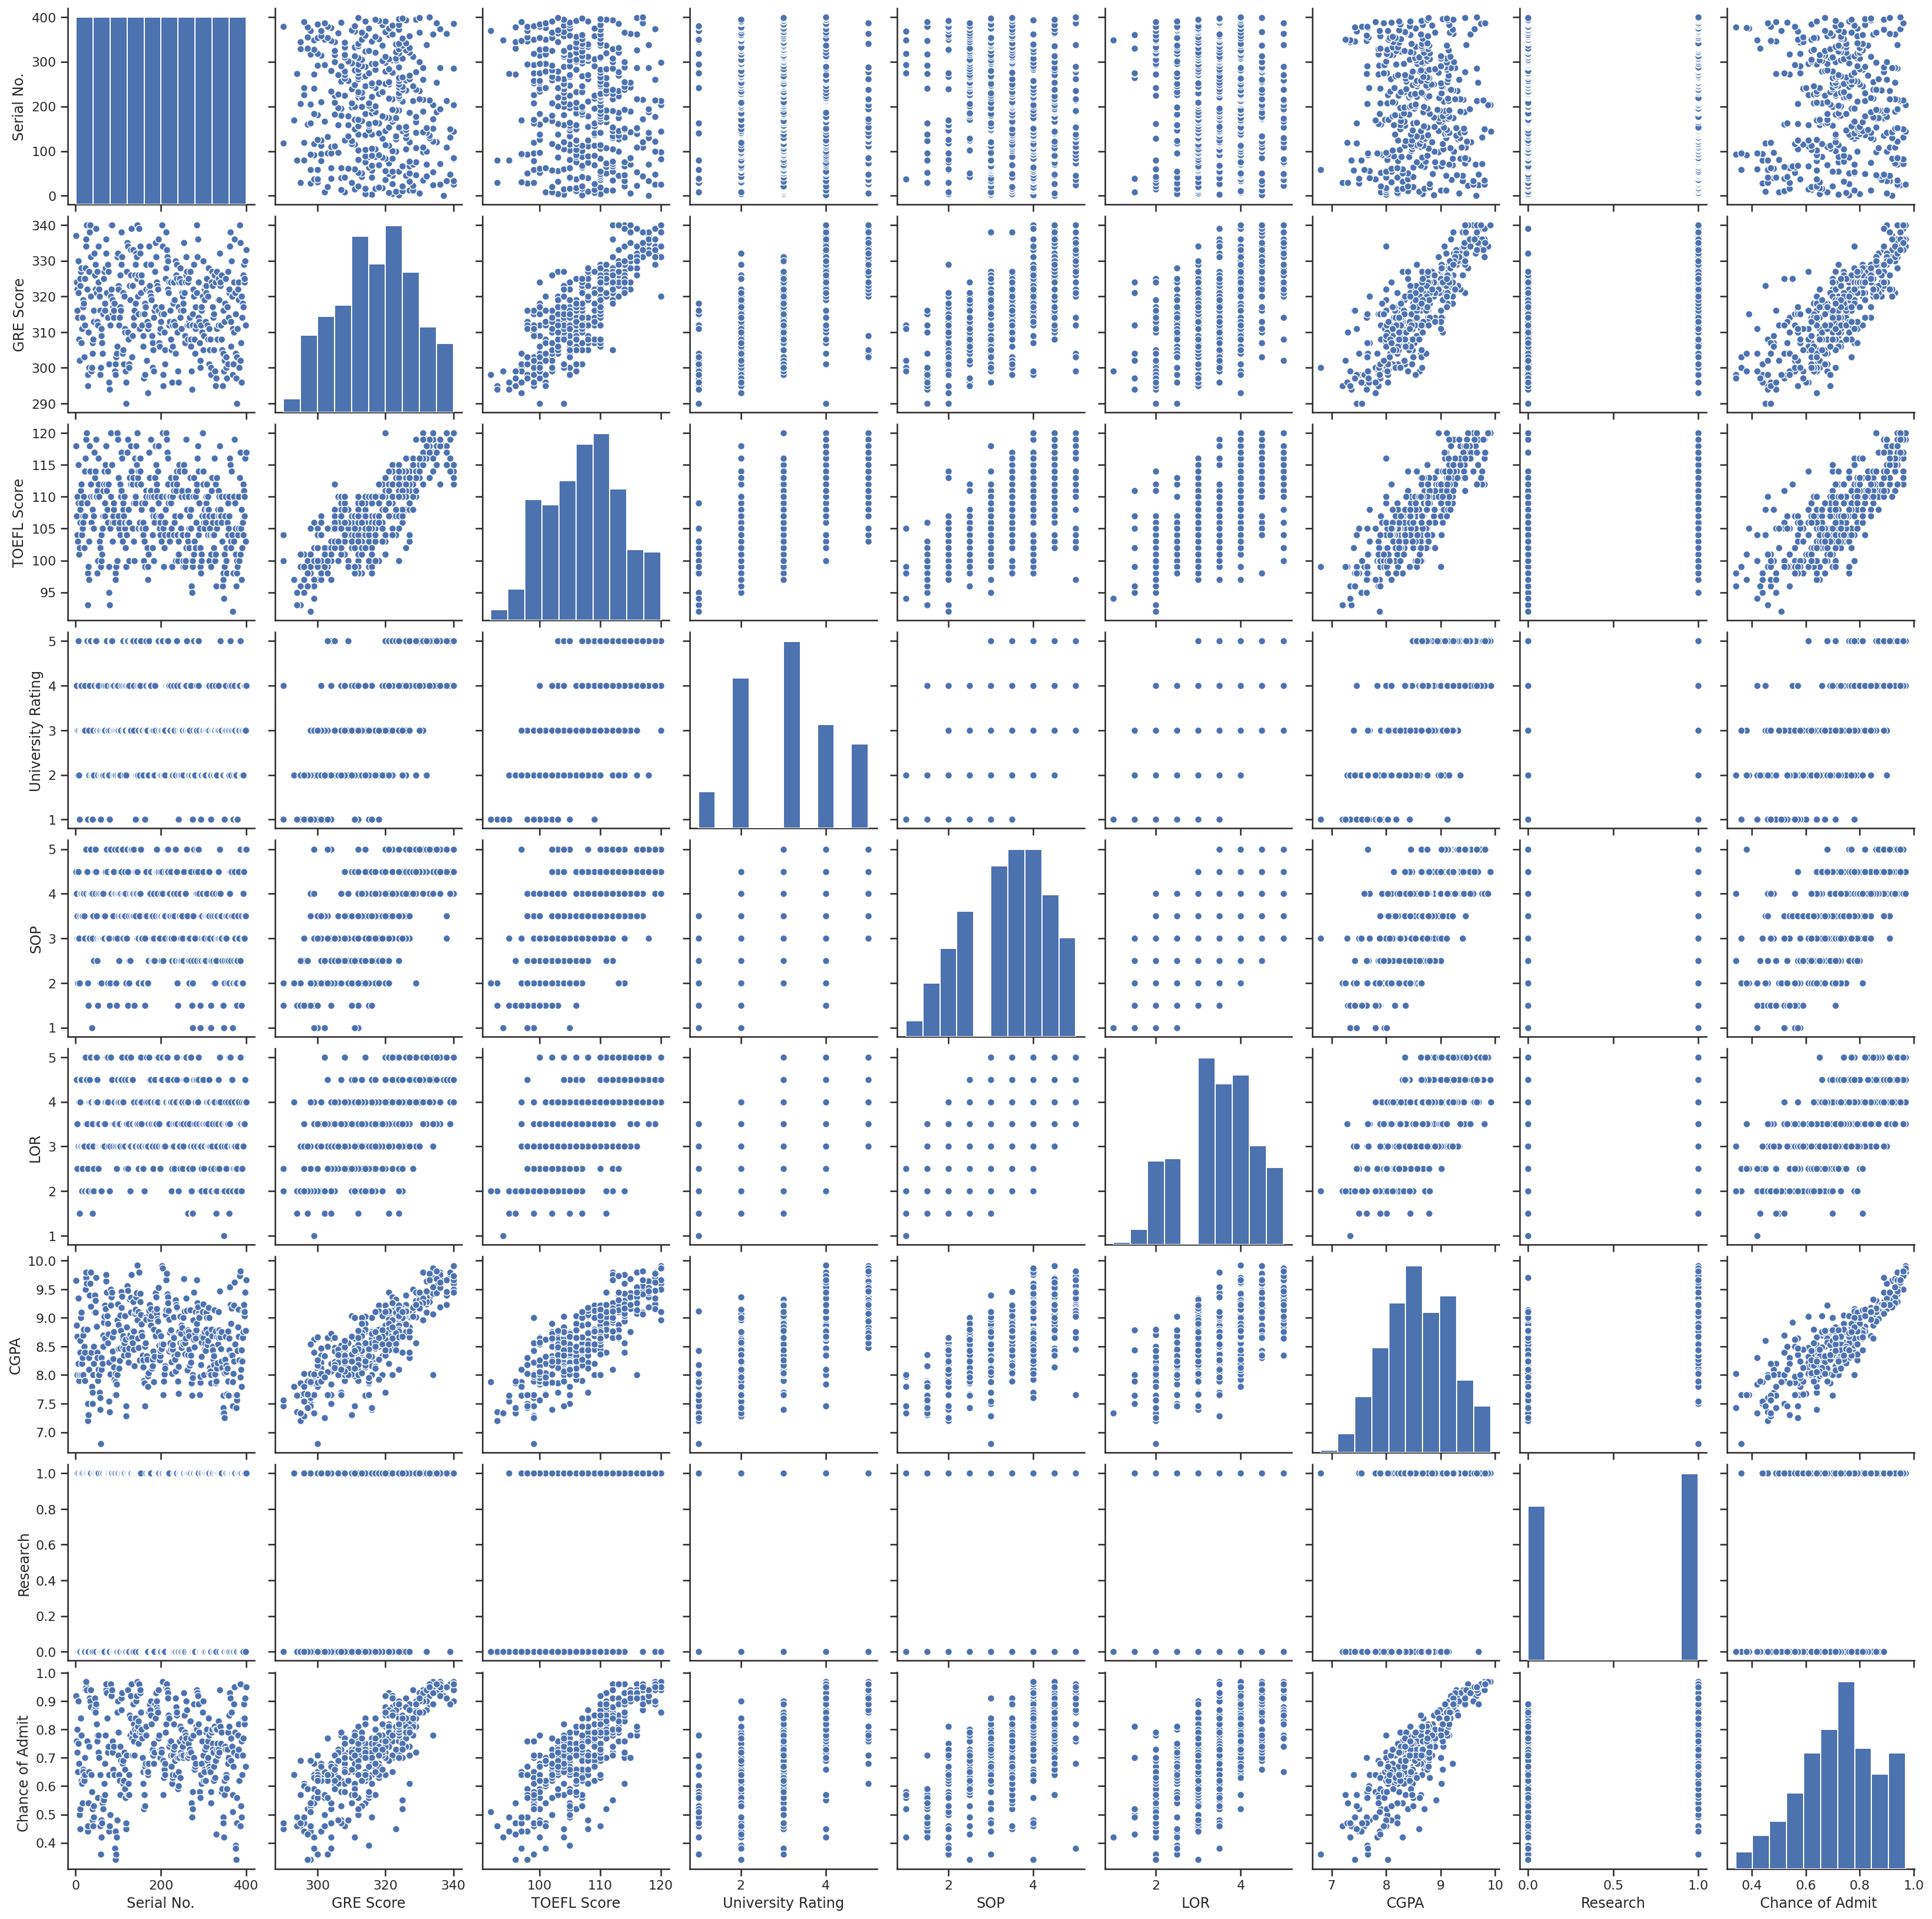

In [336]:
# Парные диаграммы
sns.pairplot(data)

In [337]:
data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

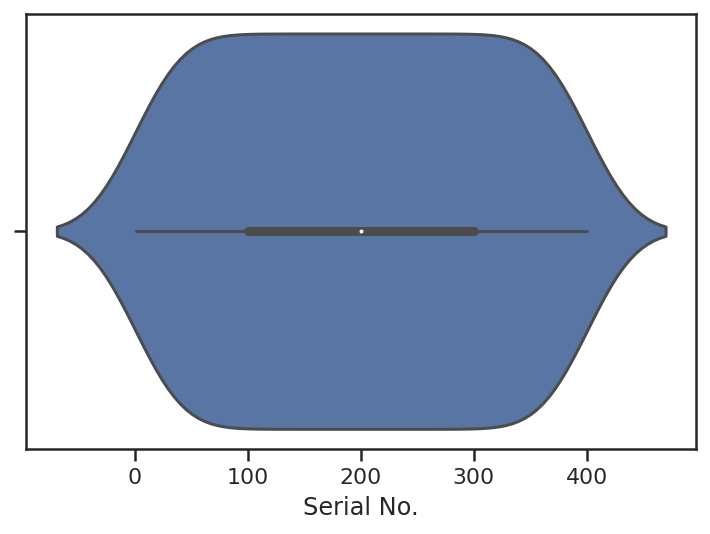

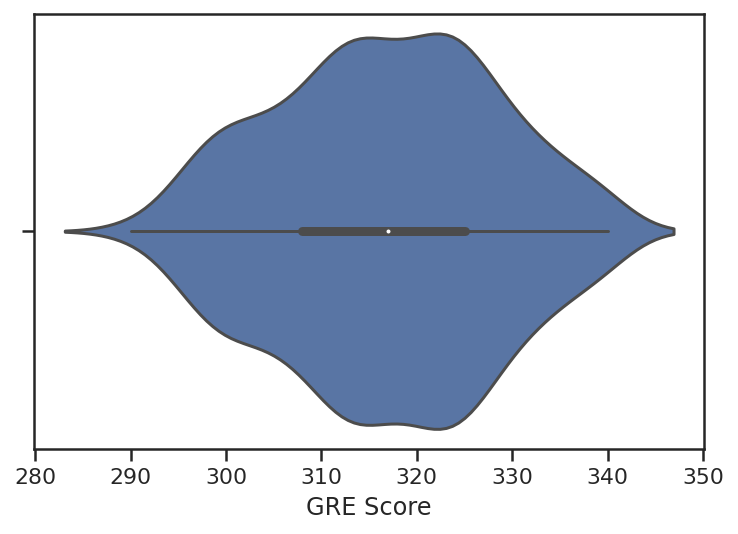

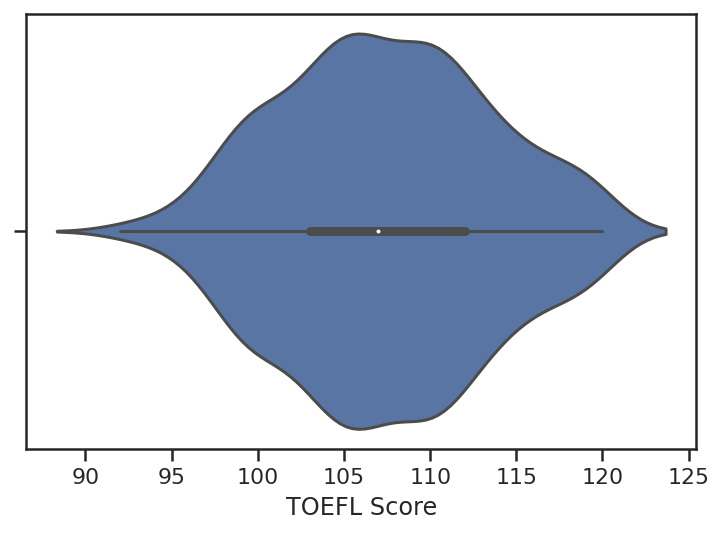

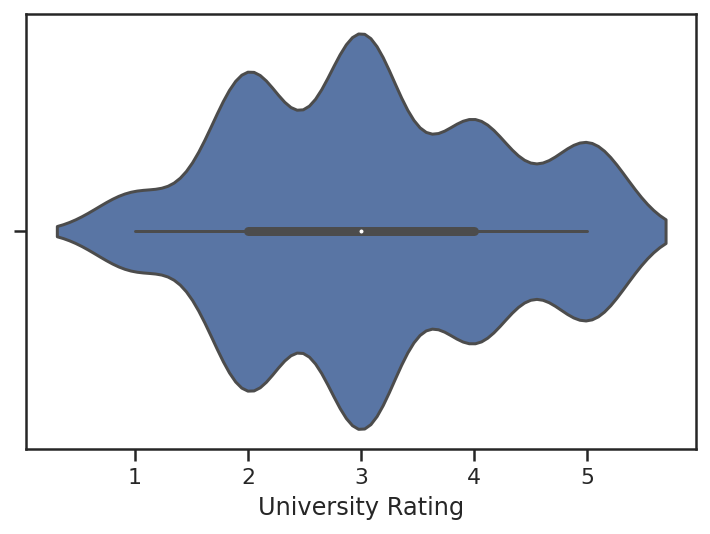

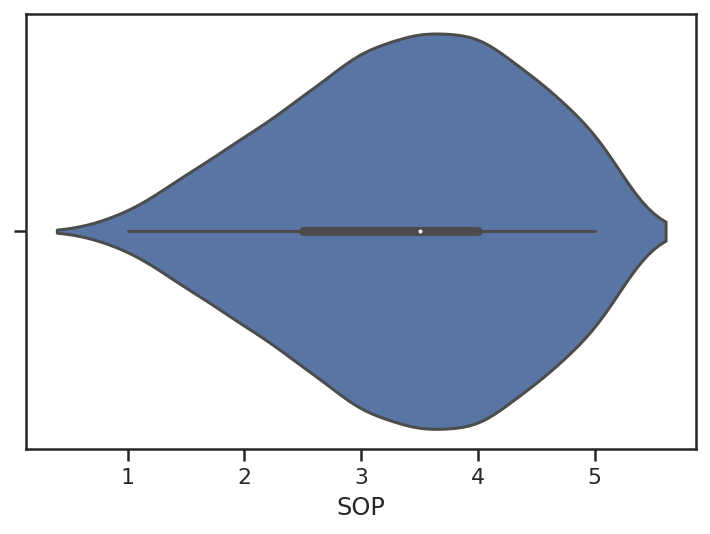

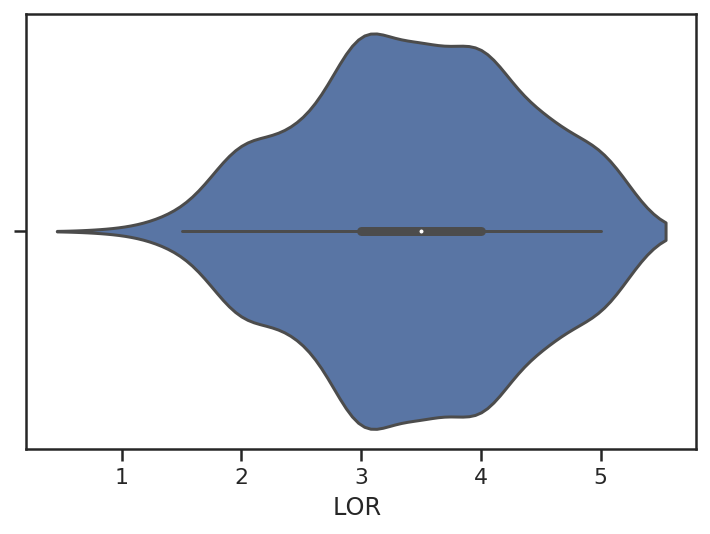

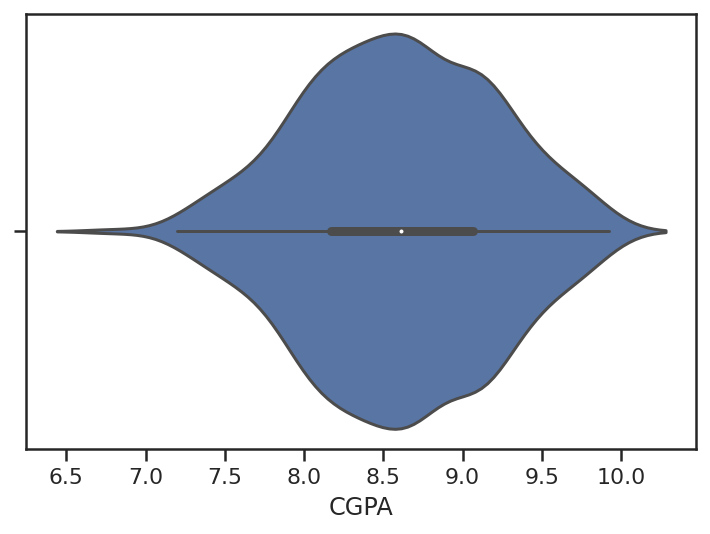

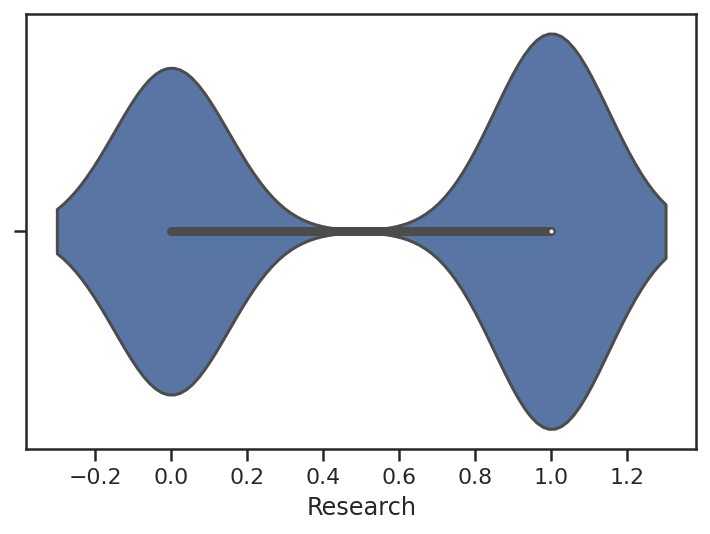

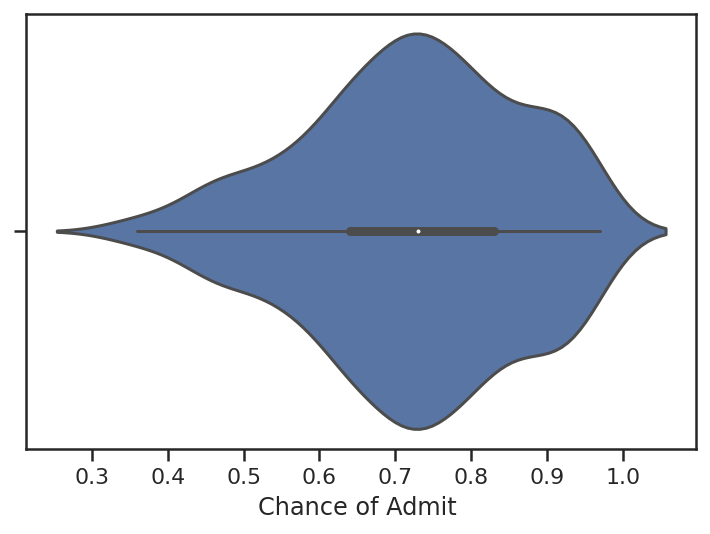

In [338]:
# Скрипичные диаграммы для числовых колонок
for col in ['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit ']:
    sns.violinplot(x=data[col])
    plt.show()

## **Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей**

In [0]:
# Числовые колонки для масштабирования
scale_cols = ['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research']

In [0]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[scale_cols])

In [0]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = sc1_data[:,i]

In [342]:
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,Serial No._scaled,GRE Score_scaled,TOEFL Score_scaled,University Rating_scaled,SOP_scaled,LOR _scaled,CGPA_scaled,Research_scaled
0,1,337,118,4,4.5,4.5,9.65,1,0.92,0.000000,0.94,0.928571,0.75,0.875,0.875,0.913462,1.0
1,2,324,107,4,4.0,4.5,8.87,1,0.76,0.002506,0.68,0.535714,0.75,0.750,0.875,0.663462,1.0
2,3,316,104,3,3.0,3.5,8.00,1,0.72,0.005013,0.52,0.428571,0.50,0.500,0.625,0.384615,1.0
3,4,322,110,3,3.5,2.5,8.67,1,0.80,0.007519,0.64,0.642857,0.50,0.625,0.375,0.599359,1.0
4,5,314,103,2,2.0,3.0,8.21,0,0.65,0.010025,0.48,0.392857,0.25,0.250,0.500,0.451923,0.0


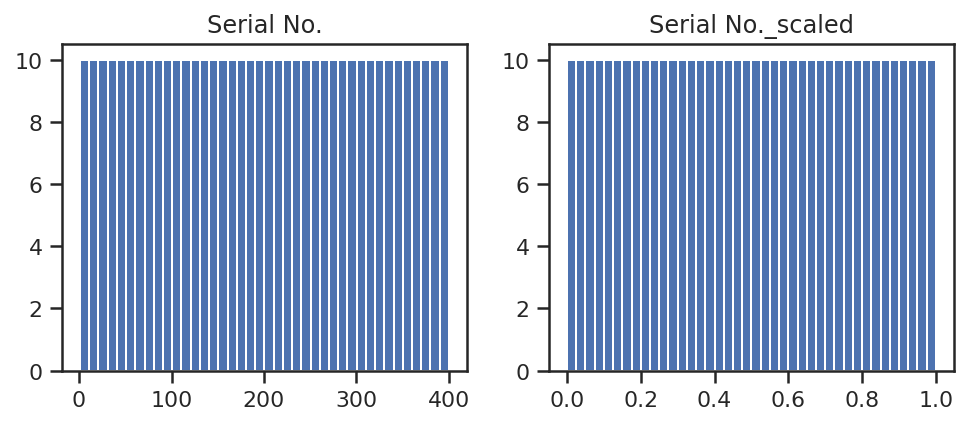

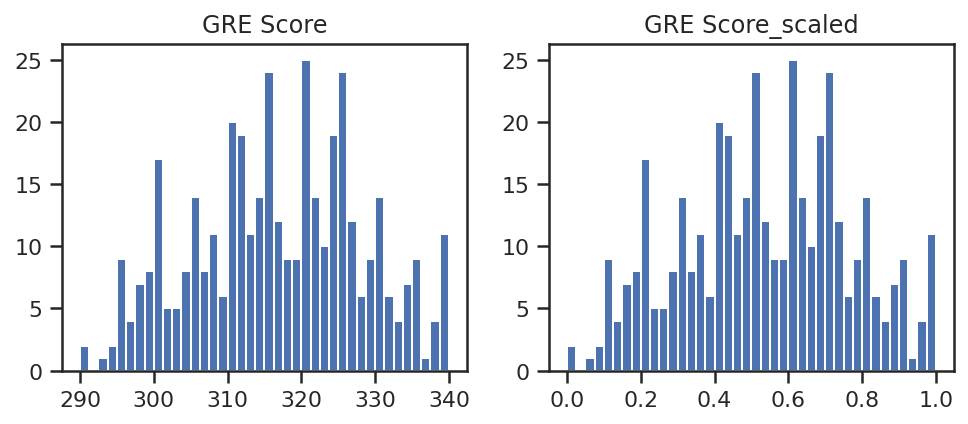

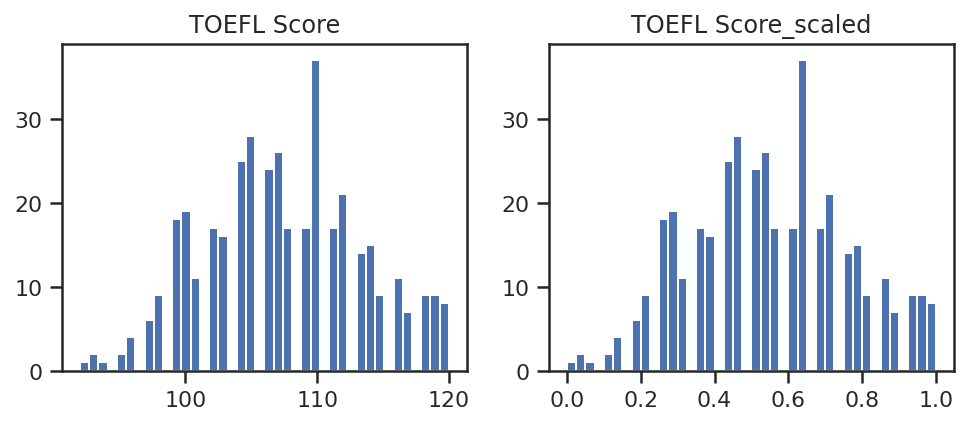

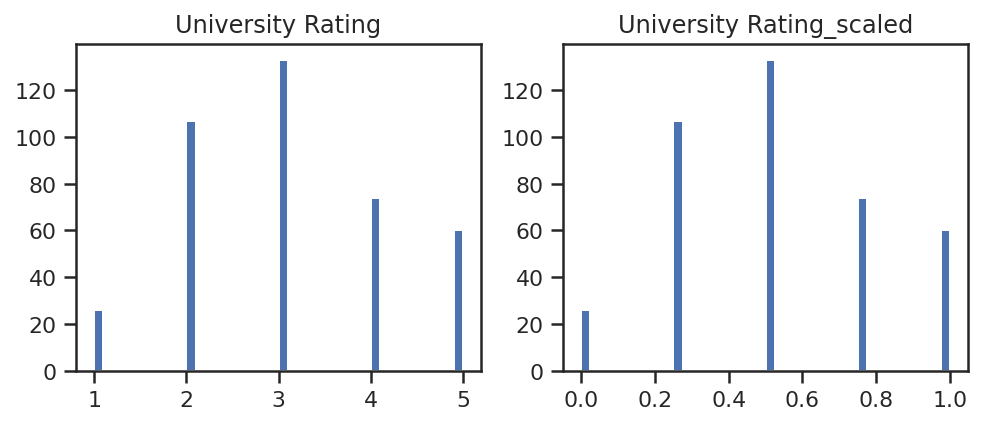

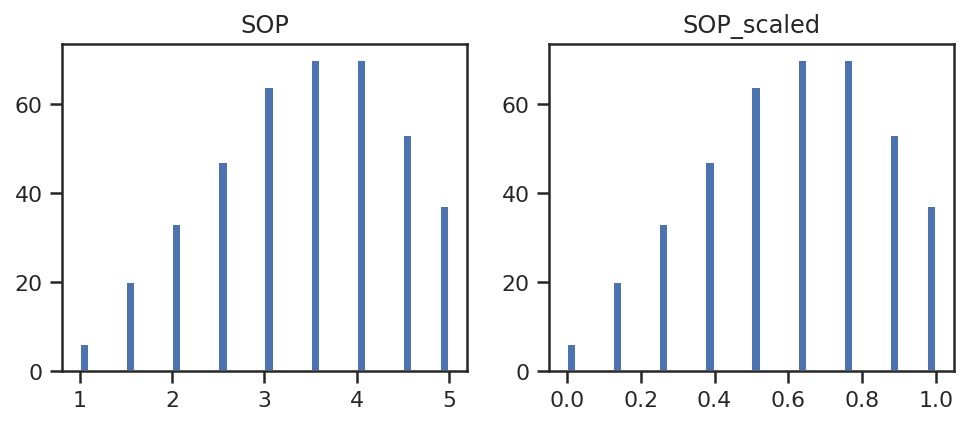

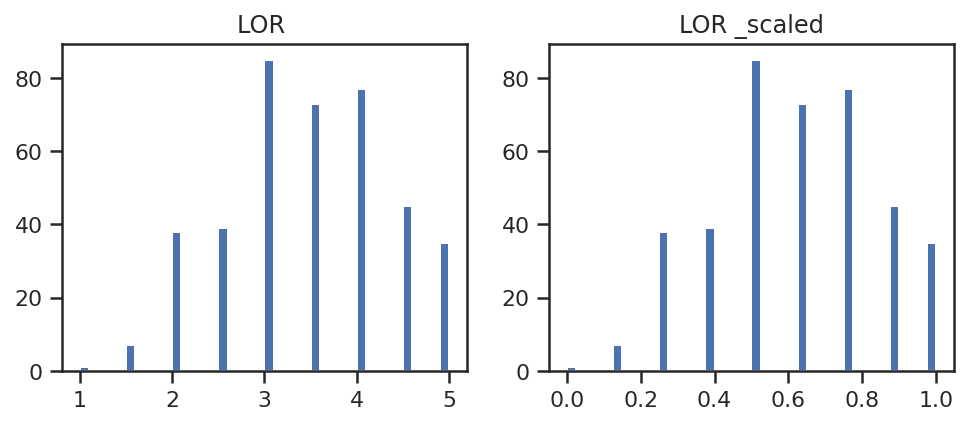

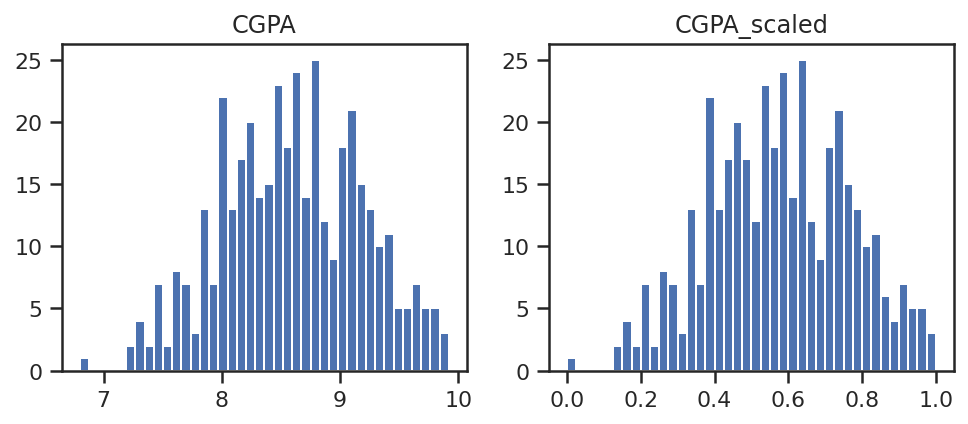

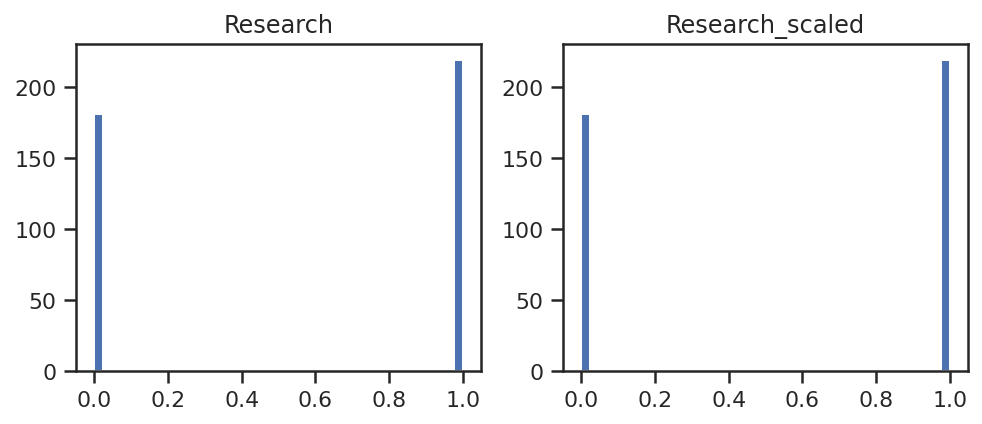

In [343]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 40)
    ax[1].hist(data[col_scaled], 40)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

## **Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения**

In [344]:
# Воспользуемся наличием тестовых выборок, 
# включив их в корреляционную матрицу
corr_cols_1 = scale_cols + ['Chance of Admit ']
corr_cols_1

['Serial No.',
 'GRE Score',
 'TOEFL Score',
 'University Rating',
 'SOP',
 'LOR ',
 'CGPA',
 'Research',
 'Chance of Admit ']

In [345]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['Chance of Admit ']
corr_cols_2

['Serial No._scaled',
 'GRE Score_scaled',
 'TOEFL Score_scaled',
 'University Rating_scaled',
 'SOP_scaled',
 'LOR _scaled',
 'CGPA_scaled',
 'Research_scaled',
 'Chance of Admit ']

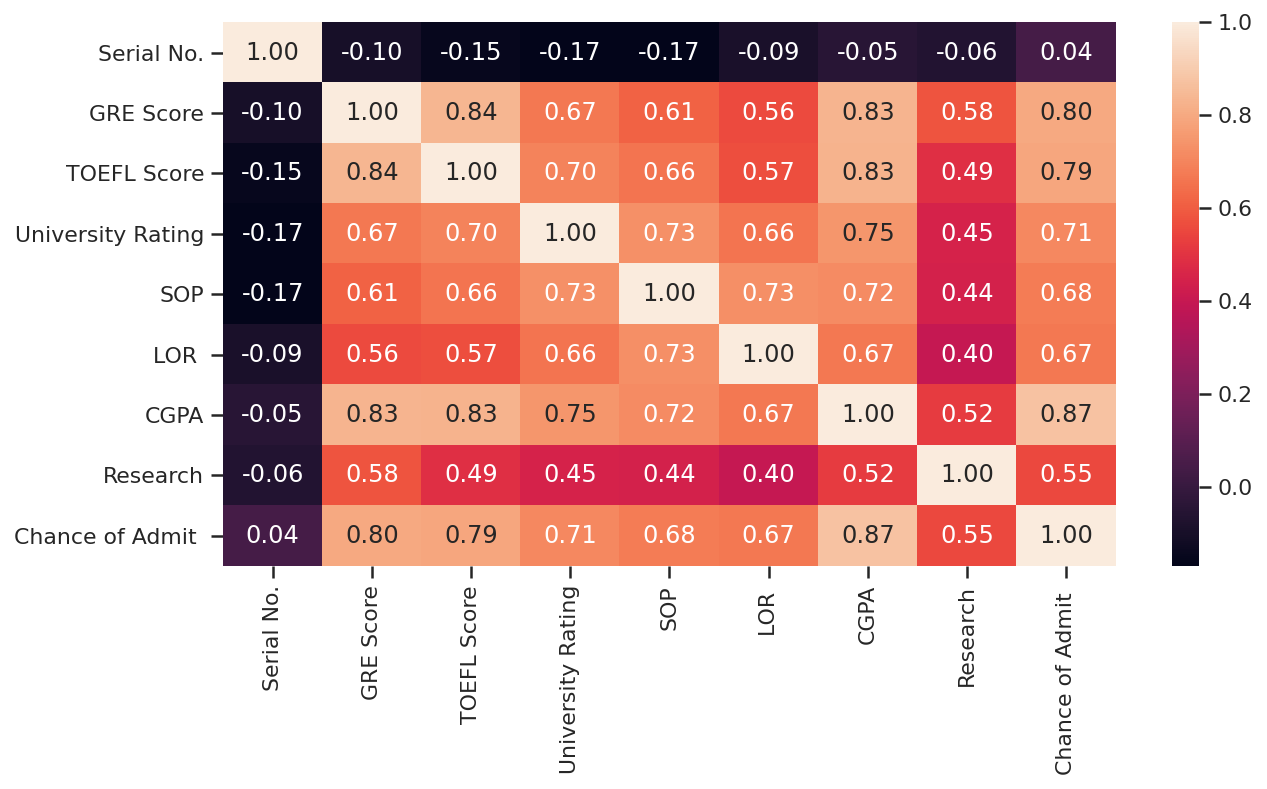

In [346]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_1].corr(), annot=True, fmt='.2f')

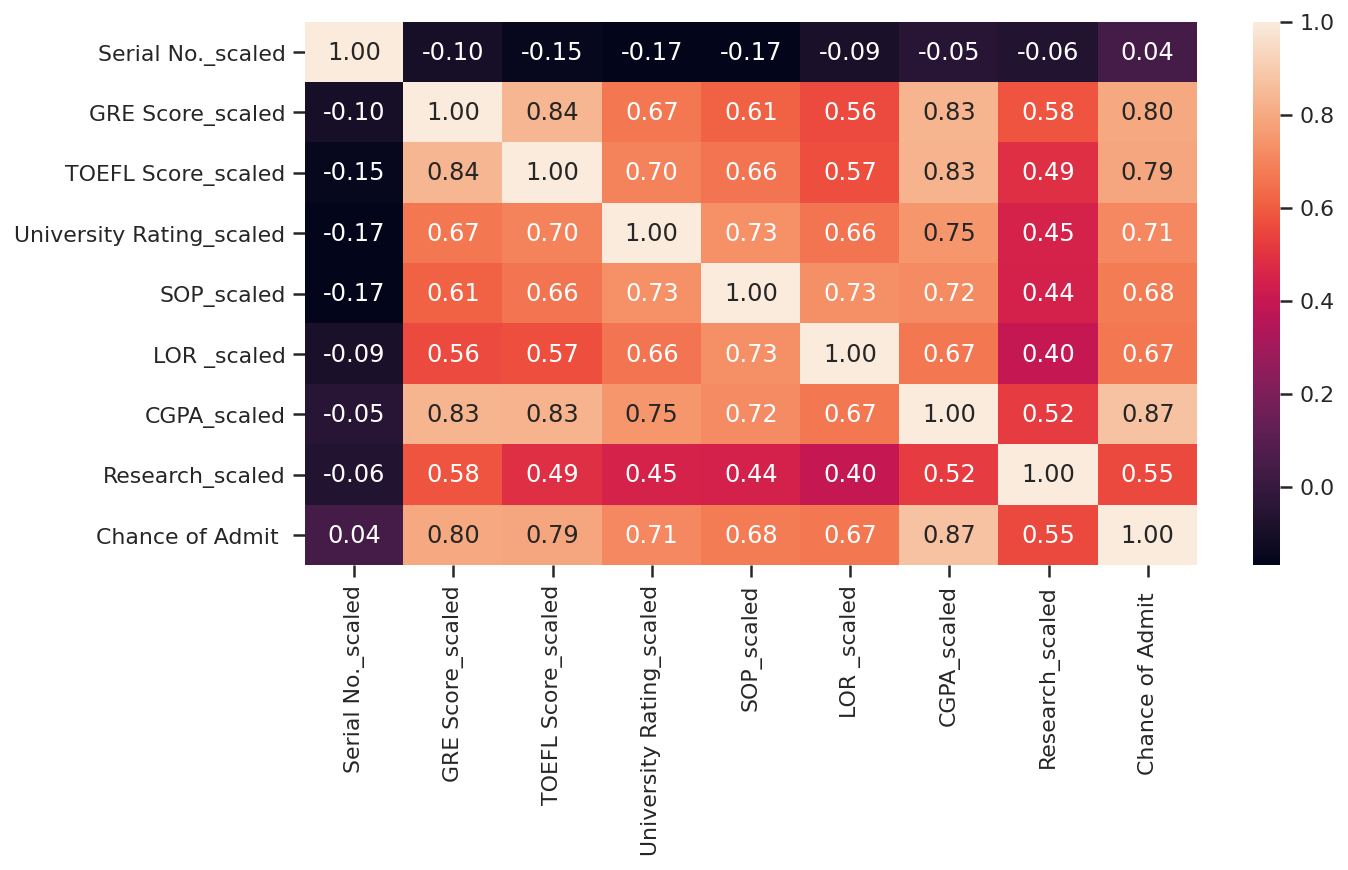

In [347]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_2].corr(), annot=True, fmt='.2f')

## **Выбор метрик для последующей оценки качества моделей**

***Для оценки качества моделей выберем следующие 3 метрики:***

**1) Mean absolute error** - средняя абсолютная ошибка

**2) Mean squared error** - средняя квадратичная ошибка

 **3) Метрика R2 или коэффициент детерминации**

In [0]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

## **Формирование обучающей и тестовой выборок на основе исходного набора данных.**

In [0]:
class_cols = ['GRE Score_scaled', 'TOEFL Score_scaled', 'University Rating_scaled', 'SOP_scaled',
       'LOR _scaled', 'CGPA_scaled', 'Research_scaled']

In [353]:
X = data[class_cols]
y = data['Chance of Admit ']
X.shape

(400, 7)

In [354]:
# С использованием метода train_test_split разделим выборку на обучающую и тестовую
regr_X_train, regr_X_test, regr_y_train, regr_y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print("regr_X_train:", X_train.shape)
print("regr_X_test:", X_test.shape)
print("regr_y_train:", y_train.shape)
print("regr_y_test:", y_test.shape)

regr_X_train: (300, 8)
regr_X_test: (100, 8)
regr_y_train: (300,)
regr_y_test: (100,)


## **Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.**

In [0]:
# Модели
regr_models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'GB':GradientBoostingRegressor()}

In [0]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [0]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(regr_X_train, regr_y_train)
    y_pred = model.predict(regr_X_test)
    
    mae = mean_absolute_error(regr_y_test, y_pred)
    mse = mean_squared_error(regr_y_test, y_pred)
    r2 = r2_score(regr_y_test, y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

In [380]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.043, MSE=0.004, R2=0.816
*****************************************************
*****************************************************
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

MAE=0.053, MSE=0.006, R2=0.737
*****************************************************
*****************************************************
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE=0.066, MSE=0.007, R2=0.711
*****************************************************
*****************************************************
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, ma

## **Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы**

In [381]:
data.shape

(400, 17)

In [382]:
n_range = np.array(range(1,240,10))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
         131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231])}]

In [383]:
%%time
regr_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(regr_X_train, regr_y_train)

CPU times: user 505 ms, sys: 788 µs, total: 506 ms
Wall time: 511 ms


In [384]:
# Лучшая модель
regr_gs.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                    weights='uniform')

In [385]:
# Лучшее значение параметров
regr_gs.best_params_

{'n_neighbors': 21}

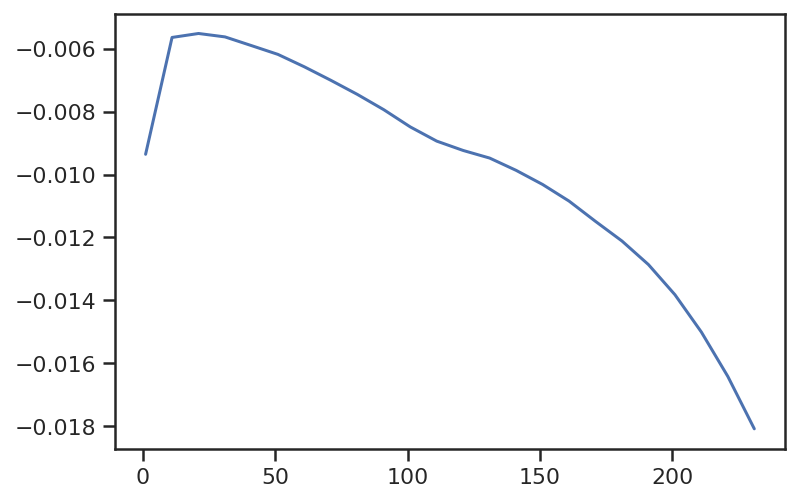

In [386]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, regr_gs.cv_results_['mean_test_score'])

### **Повторение пункта для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей**

In [0]:
regr_models_grid = {'KNN_21':regr_gs.best_estimator_}

In [388]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                    weights='uniform')

MAE=0.054, MSE=0.007, R2=0.712
*****************************************************


### **Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. Рекомендуется построение графиков обучения и валидации, влияния значений гиперпарметров на качество моделей и т.д.**

In [389]:
# Метрики качества модели
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

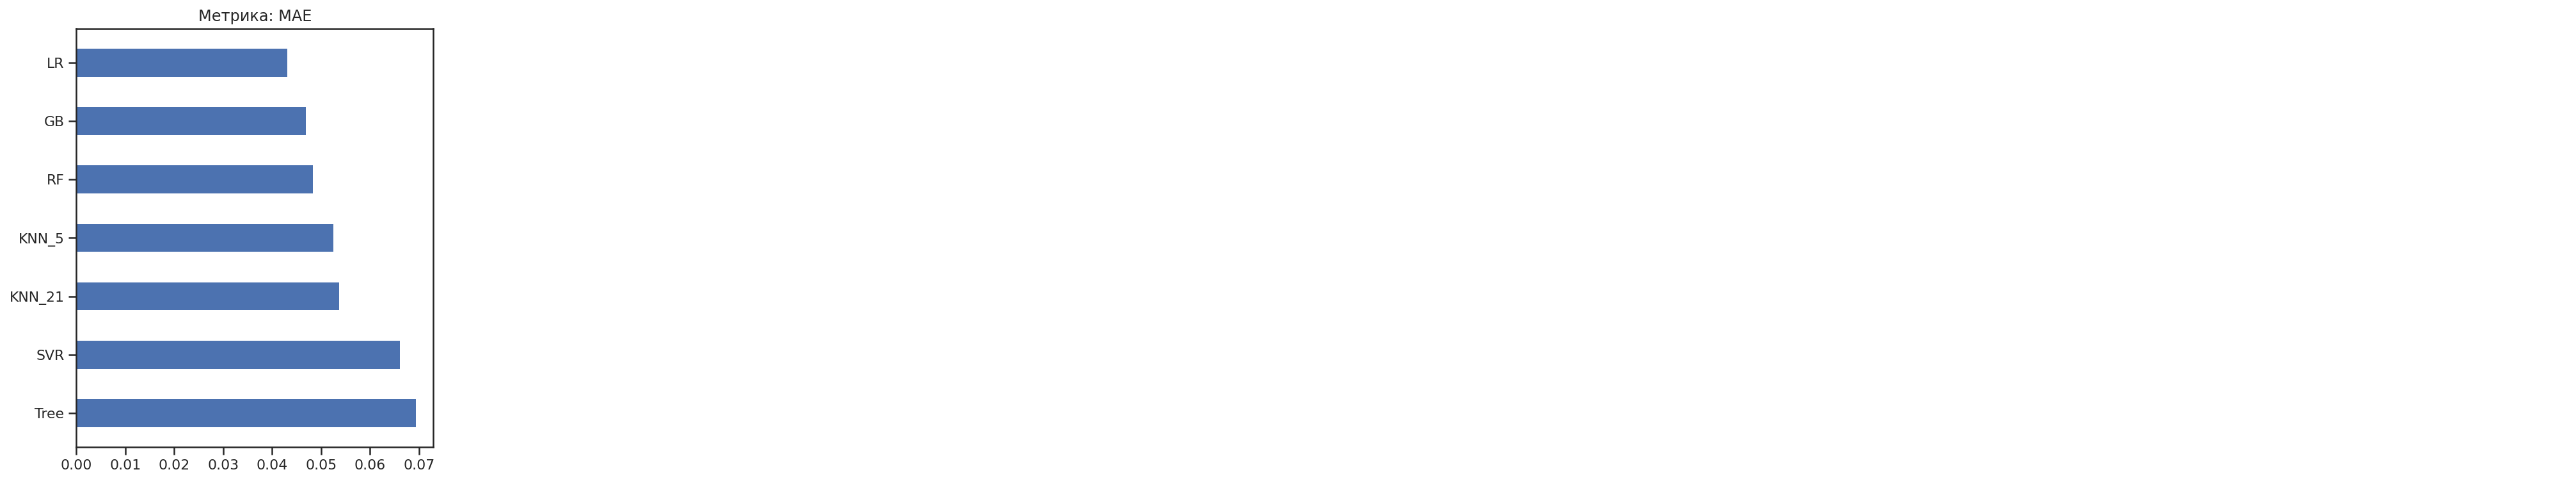

In [390]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(5, 6))

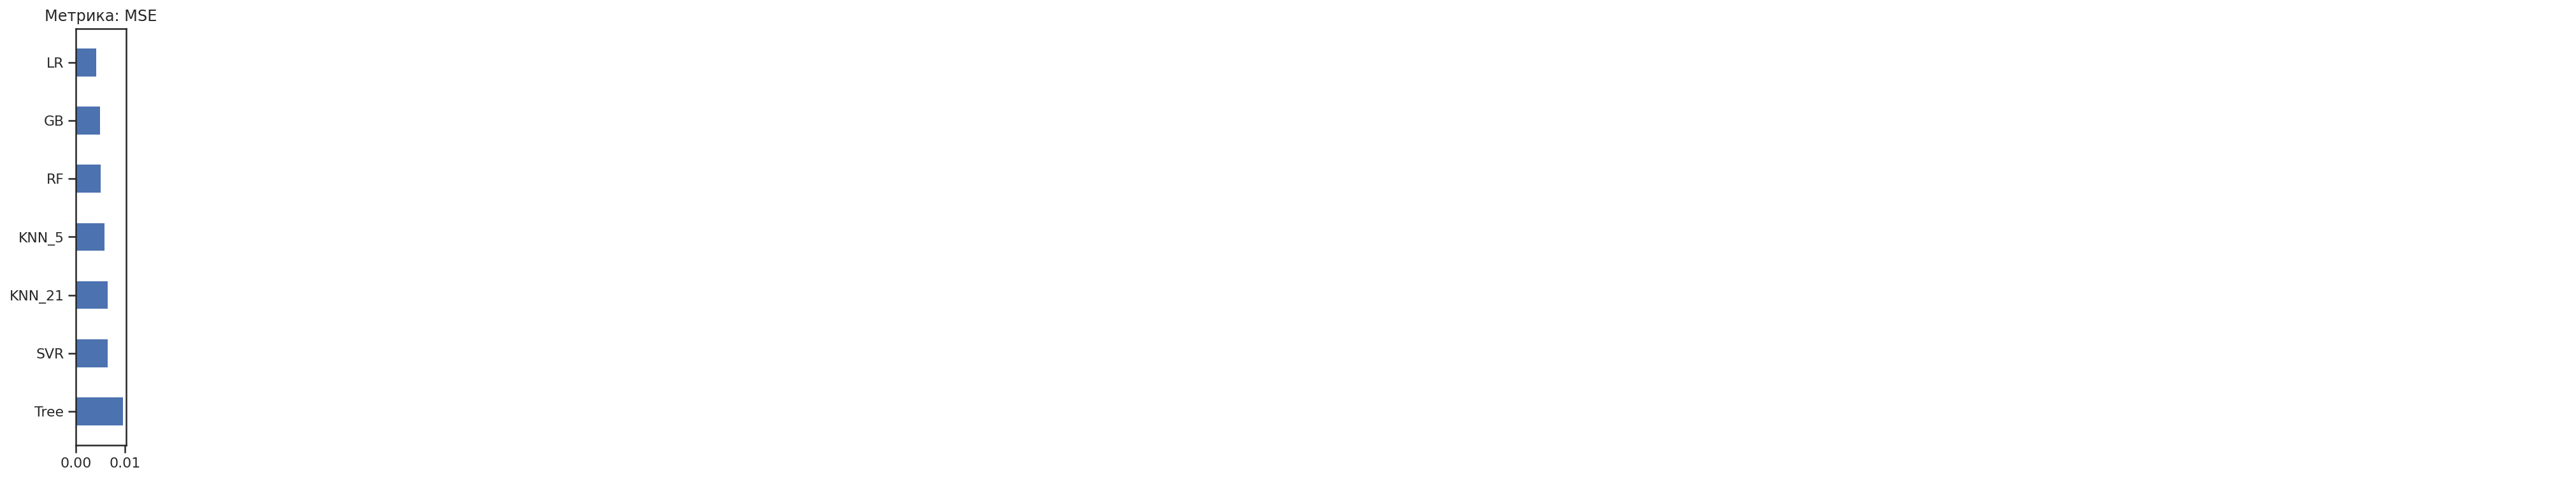

In [391]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(0.7, 6))                                                                         

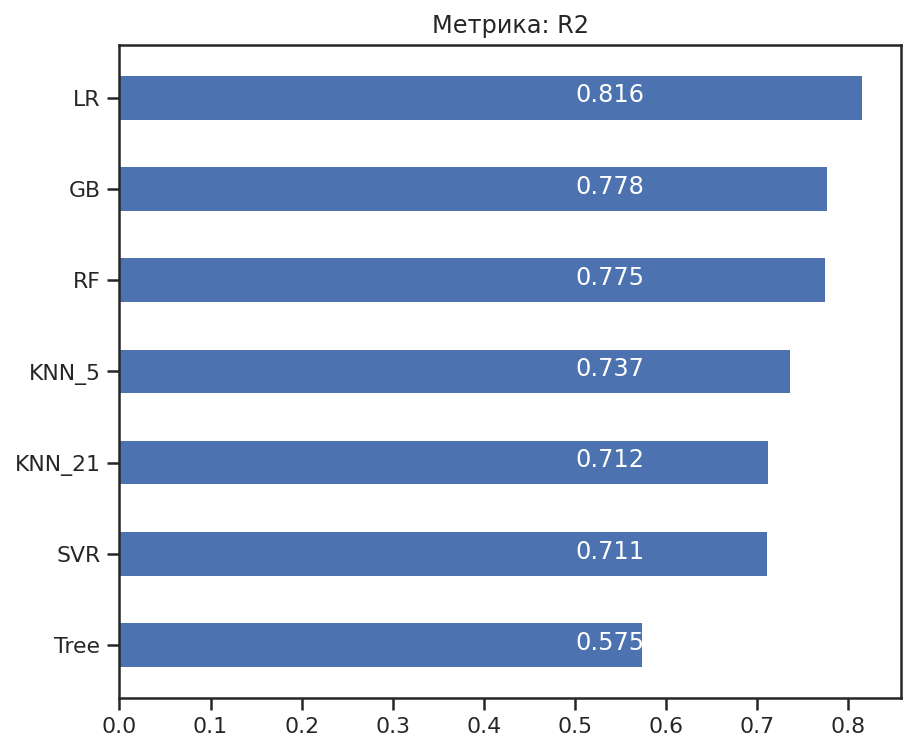

In [392]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))